In [9]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

def clean_and_merge_data(
    recs_file='recommendations.csv',
    games_file='games.csv',
    output_file='df_cleaned_500k.csv',
    chunksize=100_000,
    max_rows=500_000
):
    """
    Clean and merge large Steam datasets in chunks, limit output to avoid memory issues.
    """
    # Check file existence
    for file_path in [recs_file, games_file]:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")

    print("[INFO] Loading games.csv...")
    games = pd.read_csv(games_file, low_memory=False)

    # Clean games.csv
    print("[INFO] Cleaning games.csv...")
    needed_cols = ['app_id', 'title', 'date_release', 'price_final']
    optional_cols = ['rating', 'positive_ratio', 'price_original', 'discount']

    for col in needed_cols:
        if col not in games.columns:
            raise KeyError(f"Missing required column: {col}")
    for col in optional_cols:
        if col not in games.columns:
            games[col] = np.nan

    games.dropna(subset=['title', 'app_id'], inplace=True)
    games['date_release'] = pd.to_datetime(games['date_release'], errors='coerce')
    games['release_year'] = games['date_release'].dt.year
    games['price_final'] = pd.to_numeric(games['price_final'], errors='coerce').fillna(0)
    games['price_original'] = pd.to_numeric(games['price_original'], errors='coerce').fillna(0)
    games['discount'] = pd.to_numeric(games['discount'], errors='coerce')
    mask = games['discount'].isna() | (games['discount'] < 0) | (games['discount'] > 100)
    games.loc[mask, 'discount'] = ((games.loc[mask, 'price_original'] - games.loc[mask, 'price_final']) /
                                   games.loc[mask, 'price_original'].replace(0, np.nan) * 100).fillna(0).round(2)
    games['discount'] = games['discount'].clip(0, 100)
    games['positive_ratio'] = pd.to_numeric(games['positive_ratio'], errors='coerce').clip(0, 100)

    # Convert to dictionary for fast merging
    games_dict = games.set_index('app_id').to_dict('index')

    # Process recommendations.csv in chunks
    print("[INFO] Processing recommendations.csv in chunks...")
    first_chunk = True
    collected = 0

    try:
        for chunk in tqdm(pd.read_csv(recs_file, chunksize=chunksize, low_memory=False)):
            if 'user_id' not in chunk.columns or 'app_id' not in chunk.columns:
                raise KeyError("Missing 'user_id' or 'app_id' in recommendations.csv")

            # Clean chunk
            chunk = chunk[chunk['is_recommended'].notnull()]
            chunk['is_recommended'] = chunk['is_recommended'].astype(str).str.upper().map({
                'TRUE': 1, 'FALSE': 0, '1': 1, '0': 0, 'YES': 1, 'NO': 0, 'Y': 1, 'N': 0
            }).fillna(0).astype(int)
            chunk['hours'] = pd.to_numeric(chunk.get('hours', 0), errors='coerce').fillna(0)
            chunk.drop_duplicates(subset=['user_id', 'app_id'], inplace=True)

            # Merge with games
            merged_records = []
            for _, row in chunk.iterrows():
                app_id = row['app_id']
                if app_id in games_dict:
                    g = games_dict[app_id]
                    merged_records.append({
                        'user_id': row['user_id'],
                        'app_id': app_id,
                        'is_recommended': row['is_recommended'],
                        'hours': row['hours'],
                        'title': g.get('title'),
                        'rating': g.get('rating'),
                        'price_final': g.get('price_final'),
                        'date_release': g.get('date_release'),
                        'release_year': g.get('release_year'),
                        'positive_ratio': g.get('positive_ratio')
                    })

            merged_df = pd.DataFrame(merged_records)

            if merged_df.empty:
                continue

            # Limit to max_rows
            if collected + len(merged_df) > max_rows:
                remaining = max_rows - collected
                merged_df = merged_df.iloc[:remaining]

            merged_df.to_csv(
                output_file,
                mode='w' if first_chunk else 'a',
                header=first_chunk,
                index=False,
                encoding='utf-8-sig'
            )

            collected += len(merged_df)
            first_chunk = False

            if collected >= max_rows:
                print(f"[INFO] Reached max_rows={max_rows}, stopping early.")
                break

    except Exception as e:
        print(f"[ERROR] {e}")
        return None

    print(f"[INFO] Finished. Total cleaned rows: {collected}")
    return output_file


# Run
if __name__ == "__main__":
    clean_and_merge_data(
        recs_file='recommendations.csv',
        games_file='games.csv',
        output_file='df_cleaned_500k.csv',
        chunksize=100_000,
        max_rows=500_000
    )


[INFO] Loading games.csv...
[INFO] Cleaning games.csv...
[INFO] Processing recommendations.csv in chunks...


4it [00:35,  8.98s/it]

[INFO] Reached max_rows=500000, stopping early.
[INFO] Finished. Total cleaned rows: 500000


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime

# Set Seaborn style
sns.set_theme(style="whitegrid", font_scale=1.2)

# Load data
def load_data():
    print("Loading datasets...")
    df_cleaned = pd.read_csv('df_cleaned_500k.csv') 
    games = pd.read_csv('games.csv')                
    recommendations = pd.read_csv('recommendations.csv')
    users = pd.read_csv('users.csv')
    
    print(f"df_cleaned: {df_cleaned.shape} rows")
    return df_cleaned, games, recommendations, users

# Basic EDA
def basic_eda(df):
    print("\n--- Basic EDA ---")
    print(f"Dataset shape: {df.shape}")
    print("\nData types:")
    print(df.dtypes)
    
    print("\nMissing values:")
    print(df.isnull().sum())
    
    print("\nDescriptive stats:")
    print(df.describe().T)

# Recommendation analysis
def recommendation_analysis(df):
    print("\n--- Recommendation Analysis ---")
    
    # Recommendation distribution
    if 'is_recommended' in df.columns:
        rec_counts = df['is_recommended'].value_counts(normalize=True) * 100
        print(f"\nRecommended: {rec_counts.get(1,0):.2f}%")
        print(f"Not Recommended: {rec_counts.get(0,0):.2f}%")
        
        plt.figure(figsize=(8, 5))
        sns.countplot(x='is_recommended', data=df)
        plt.title('Recommendation Distribution')
        plt.xlabel('Recommendation')
        plt.xticks([0, 1], ['Not Recommended', 'Recommended'])
        plt.ylabel('Count')
        plt.savefig('recommendation_distribution.png')
        plt.close()
    
    # Sentiment analysis (positive_ratio)
    if 'positive_ratio' in df.columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(df['positive_ratio'], bins=20)
        plt.title('Positive Ratio Distribution')
        plt.xlabel('Positive Ratio')
        plt.ylabel('Count')
        plt.savefig('sentiment_distribution.png')
        plt.close()
        
        print(f"\nPositive Ratio Stats:")
        print(df['positive_ratio'].describe())

# Game analysis
def game_analysis(df):
    print("\n--- Game Analysis ---")
    
    # Game popularity (top 10 by app_id)
    if 'app_id' in df.columns:
        game_counts = df['app_id'].value_counts().head(10)
        print(f"\nTop 10 games by number of records:")
        top_games = game_counts.reset_index()
        top_games.columns = ['app_id', 'num_records']
        
        if 'title' in df.columns:
            game_titles = df[['app_id', 'title']].drop_duplicates()
            top_games = top_games.merge(game_titles, on='app_id', how='left')
        print(top_games)
    
    # Rating analysis
    if 'rating' in df.columns:
        # Check if rating is already numeric or needs conversion
        df_plot = df.copy()
        if not pd.api.types.is_numeric_dtype(df['rating']):
            # Display unique rating values
            print("\nUnique rating values:")
            print(df['rating'].value_counts())
            
            # Create a mapping for text ratings if needed
            try:
                rating_map = {
                    'Overwhelmingly Positive': 5.0,
                    'Very Positive': 4.5,
                    'Positive': 4.0,
                    'Mostly Positive': 3.5,
                    'Mixed': 3.0,
                    'Mostly Negative': 2.5,
                    'Negative': 2.0,
                    'Very Negative': 1.5,
                    'Overwhelmingly Negative': 1.0
                }
                df_plot['rating_numeric'] = df['rating'].map(rating_map)
                print("Converted text ratings to numeric scale (1-5)")
                
                # Use the numeric rating for the plot
                plt.figure(figsize=(8, 5))
                sns.histplot(df_plot['rating_numeric'].dropna(), bins=10)
                plt.title('Game Rating Distribution (Converted)')
                plt.xlabel('Rating (Numeric)')
                plt.ylabel('Count')
                plt.savefig('rating_distribution.png')
                plt.close()
                
                print(f"\nConverted Rating stats:")
                print(df_plot['rating_numeric'].describe())
            except:
                print("Could not convert ratings to numeric format.")
        else:
            # If rating is already numeric
            plt.figure(figsize=(8, 5))
            sns.histplot(df['rating'], bins=20)
            plt.title('Game Rating Distribution')
            plt.xlabel('Rating')
            plt.ylabel('Count')
            plt.savefig('rating_distribution.png')
            plt.close()
            
            print(f"\nRating stats:")
            print(df['rating'].describe())
        
        # Relationship between rating and recommendation
        if 'is_recommended' in df.columns:
            if not pd.api.types.is_numeric_dtype(df['rating']) and 'rating_numeric' in df_plot.columns:
                plt.figure(figsize=(8, 5))
                sns.boxplot(x='is_recommended', y='rating_numeric', data=df_plot)
                plt.title('Rating vs. Recommendation')
                plt.xlabel('Recommendation')
                plt.xticks([0, 1], ['Not Recommended', 'Recommended'])
                plt.ylabel('Rating (Numeric)')
                plt.savefig('rating_vs_recommendation.png')
                plt.close()
            elif pd.api.types.is_numeric_dtype(df['rating']):
                plt.figure(figsize=(8, 5))
                sns.boxplot(x='is_recommended', y='rating', data=df)
                plt.title('Rating vs. Recommendation')
                plt.xlabel('Recommendation')
                plt.xticks([0, 1], ['Not Recommended', 'Recommended'])
                plt.ylabel('Rating')
                plt.savefig('rating_vs_recommendation.png')
                plt.close()

# Playtime analysis
def playtime_analysis(df):
    print("\n--- Playtime Analysis ---")
    
    if 'hours' in df.columns:
        # Filter out extreme values
        hours_filtered = df[df['hours'] < df['hours'].quantile(0.95)]
        
        plt.figure(figsize=(8, 5))
        sns.histplot(hours_filtered['hours'], bins=30)
        plt.title('Playtime Distribution')
        plt.xlabel('Hours Played')
        plt.ylabel('Count')
        plt.savefig('playtime_distribution.png')
        plt.close()
        
        print(f"\nPlaytime stats:")
        print(df['hours'].describe())
        
        # Relationship between playtime and recommendation
        if 'is_recommended' in df.columns:
            plt.figure(figsize=(8, 5))
            sns.boxplot(x='is_recommended', y='hours', data=hours_filtered)
            plt.title('Playtime vs. Recommendation')
            plt.xlabel('Recommendation')
            plt.xticks([0, 1], ['Not Recommended', 'Recommended'])
            plt.ylabel('Hours')
            plt.savefig('playtime_vs_recommendation.png')
            plt.close()

# Correlation analysis - FIXED
def correlation_analysis(df):
    print("\n--- Correlation Analysis ---")
    
    # Create a copy of the dataframe for correlation analysis
    df_corr = df.copy()
    
    # Handle the rating column if it's not numeric
    if 'rating' in df.columns and not pd.api.types.is_numeric_dtype(df['rating']):
        try:
            # Attempt to create a numeric rating column
            rating_map = {
                'Overwhelmingly Positive': 5.0,
                'Very Positive': 4.5,
                'Positive': 4.0,
                'Mostly Positive': 3.5,
                'Mixed': 3.0,
                'Mostly Negative': 2.5,
                'Negative': 2.0,
                'Very Negative': 1.5,
                'Overwhelmingly Negative': 1.0
            }
            df_corr['rating_numeric'] = df['rating'].map(rating_map)
            print("Created 'rating_numeric' from text ratings")
        except:
            print("Could not convert ratings to numeric format")
    
    # Define numeric features to use
    potential_features = ['hours', 'price_final', 'positive_ratio']
    
    # Add the correct rating column depending on whether conversion worked
    if 'rating' in df.columns:
        if pd.api.types.is_numeric_dtype(df['rating']):
            potential_features.append('rating')
        elif 'rating_numeric' in df_corr.columns:
            potential_features.append('rating_numeric')
    
    # Filter to ensure only numeric columns are used
    num_features = [col for col in potential_features if col in df_corr.columns and pd.api.types.is_numeric_dtype(df_corr[col])]
    
    print(f"Using numeric features for correlation: {num_features}")
    
    if len(num_features) > 1:
        # Calculate correlation only for numeric columns
        corr = df_corr[num_features].corr()
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Feature Correlation Matrix')
        plt.savefig('feature_correlation.png')
        plt.close()
        
        print("\nCorrelation matrix:")
        print(corr)
    else:
        print("Not enough numeric features for correlation analysis")

# Release year analysis
def release_year_analysis(df):
    print("\n--- Release Year Analysis ---")
    
    if 'release_year' in df.columns:
        year_counts = df['release_year'].value_counts().sort_index()
        plt.figure(figsize=(10, 5))
        year_counts.plot(kind='bar')
        plt.title('Number of Games by Release Year')
        plt.xlabel('Release Year')
        plt.ylabel('Game Count')
        plt.xticks(rotation=45)
        plt.savefig('games_by_year.png')
        plt.close()
        
        # Check if rating is numeric or has been converted
        if 'rating' in df.columns and pd.api.types.is_numeric_dtype(df['rating']):
            year_ratings = df.groupby('release_year')['rating'].mean().sort_index()
            plt.figure(figsize=(10, 5))
            year_ratings.plot(kind='line', marker='o')
            plt.title('Average Rating by Release Year')
            plt.xlabel('Release Year')
            plt.ylabel('Average Rating')
            plt.grid(True)
            plt.savefig('rating_by_year.png')
            plt.close()
        elif 'rating_numeric' in df.columns:
            # Use converted ratings
            year_ratings = df.groupby('release_year')['rating_numeric'].mean().sort_index()
            plt.figure(figsize=(10, 5))
            year_ratings.plot(kind='line', marker='o')
            plt.title('Average Rating by Release Year')
            plt.xlabel('Release Year')
            plt.ylabel('Average Rating (Converted)')
            plt.grid(True)
            plt.savefig('rating_by_year.png')
            plt.close()

# Feature engineering
def feature_engineering(df):
    print("\n--- Feature Engineering ---")
    df_features = df.copy()
    
    # Handle rating column if it's not numeric
    if 'rating' in df.columns and not pd.api.types.is_numeric_dtype(df['rating']):
        try:
            # Create a numeric rating feature
            rating_map = {
                'Overwhelmingly Positive': 5.0,
                'Very Positive': 4.5,
                'Positive': 4.0,
                'Mostly Positive': 3.5,
                'Mixed': 3.0,
                'Mostly Negative': 2.5,
                'Negative': 2.0,
                'Very Negative': 1.5,
                'Overwhelmingly Negative': 1.0
            }
            df_features['rating_numeric'] = df['rating'].map(rating_map)
            print("Created 'rating_numeric' from text ratings")
        except:
            print("Could not convert ratings to numeric format")
    
    # 1. Date feature
    if 'date_release' in df_features.columns:
        if not pd.api.types.is_datetime64_dtype(df_features['date_release']):
            df_features['date_release'] = pd.to_datetime(df_features['date_release'], errors='coerce')
        current_date = datetime.now()
        df_features['days_since_release'] = (current_date - df_features['date_release']).dt.days
        print("Created 'days_since_release' feature")
    
    # 2. Numeric feature scaling
    num_cols = ['hours', 'price_final']
    
    # Add appropriate rating column
    if 'rating' in df_features.columns and pd.api.types.is_numeric_dtype(df_features['rating']):
        num_cols.append('rating')
    elif 'rating_numeric' in df_features.columns:
        num_cols.append('rating_numeric')
    
    num_cols = [col for col in num_cols if col in df_features.columns]
    
    if num_cols:
        scaler = StandardScaler()
        df_features[[f"scaled_{col}" for col in num_cols]] = scaler.fit_transform(df_features[num_cols])
        print(f"Scaled numeric features: {num_cols}")
    
    # 3. Interaction feature
    if 'hours' in df_features.columns:
        if 'rating' in df_features.columns and pd.api.types.is_numeric_dtype(df_features['rating']):
            df_features['hours_rating'] = df_features['hours'] * df_features['rating']
            print("Created interaction feature: hours × rating")
        elif 'rating_numeric' in df_features.columns:
            df_features['hours_rating'] = df_features['hours'] * df_features['rating_numeric']
            print("Created interaction feature: hours × rating_numeric")
    
    # 4. Binary indicator
    if 'price_final' in df_features.columns:
        df_features['is_free'] = (df_features['price_final'] == 0).astype(int)
        print("Created 'is_free' indicator")
    
    # 5. Sentiment classification
    if 'positive_ratio' in df_features.columns:
        bins = [0, 0.3, 0.7, 1.0]
        labels = ['Negative', 'Neutral', 'Positive']
        df_features['sentiment'] = pd.cut(df_features['positive_ratio'], bins=bins, labels=labels)
        print("Created sentiment classification feature")
    
    # 6. Game age feature
    if 'release_year' in df_features.columns:
        current_year = datetime.now().year
        df_features['game_age'] = current_year - df_features['release_year']
        print("Created 'game_age' feature")
    
    print("\nNewly created features:")
    new_features = [col for col in df_features.columns if col not in df.columns]
    for col in new_features:
        print(f"- {col}")
    
    return df_features

def create_interaction_matrix(df):
    """
    Create a user-game interaction matrix based on 'is_recommended'.
    """
    if 'user_id' in df.columns and 'app_id' in df.columns and 'is_recommended' in df.columns:
        print("\n--- Creating User-Game Interaction Matrix ---")
        interaction_matrix = df.pivot_table(
            index='user_id', 
            columns='app_id', 
            values='is_recommended', 
            aggfunc='mean'
        )
        density = interaction_matrix.count().sum() / (interaction_matrix.shape[0] * interaction_matrix.shape[1])
        print(f"Interaction matrix shape: {interaction_matrix.shape}")
        print(f"Matrix density: {density:.4f} ({density*100:.2f}%)")
        return interaction_matrix
    else:
        print("Missing columns for creating the interaction matrix.")
        return None

def main():
    # Load data
    df_cleaned, games, recommendations, users = load_data()
    
    # Perform EDA
    basic_eda(df_cleaned)
    recommendation_analysis(df_cleaned)
    game_analysis(df_cleaned)
    playtime_analysis(df_cleaned)
    correlation_analysis(df_cleaned)  # Fixed function
    release_year_analysis(df_cleaned)
    
    # Feature engineering
    df_features = feature_engineering(df_cleaned)
    
    # Create user-game matrix (now using 'is_recommended')
    interaction_matrix = create_interaction_matrix(df_cleaned)
    
    # Save processed data
    df_features.to_csv('df_features.csv', index=False)
    print("\nFeature engineering completed. Saved the processed dataset as 'df_features.csv'")

if __name__ == "__main__":
    main()


Loading datasets...
df_cleaned: (500000, 10) rows

--- Basic EDA ---
Dataset shape: (500000, 10)

Data types:
user_id             int64
app_id              int64
is_recommended      int64
hours             float64
title              object
rating             object
price_final       float64
date_release       object
release_year        int64
positive_ratio      int64
dtype: object

Missing values:
user_id           0
app_id            0
is_recommended    0
hours             0
title             0
rating            0
price_final       0
date_release      0
release_year      0
positive_ratio    0
dtype: int64

Descriptive stats:
                   count          mean           std     min         25%  \
user_id         500000.0  7.264415e+06  4.086596e+06     2.0  3830455.25   
app_id          500000.0  6.193821e+05  5.056661e+05   440.0   255710.00   
is_recommended  500000.0  8.455500e-01  3.613799e-01     0.0        1.00   
hours           500000.0  2.010337e+02  2.366772e+02     0.0  

In [11]:
import pandas as pd

df_meta = pd.read_json('games_metadata.json', lines=True) 
df_meta.columns
df_meta.head()


,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

def map_rating_to_label(r):
    rating_map = {
        "Overwhelmingly Positive": 5.0,
        "Very Positive": 4.5,
        "Positive": 4.0,
        "Mostly Positive": 3.5,
        "Mixed": 3.0,
        "Mostly Negative": 2.5,
        "Negative": 2.0,
        "Very Negative": 1.5,
        "Overwhelmingly Negative": 1.0
    }
    return rating_map.get(r, None)

def main():
    df = pd.read_csv('df_cleaned_500k.csv')
    print("[INFO] Original shape:", df.shape)
    print("Columns:", df.columns.tolist())

    # Map rating to a continuous score
    df['sentiment_label'] = df['rating'].apply(map_rating_to_label)
    before_drop = df.shape[0]
    df.dropna(subset=['sentiment_label'], inplace=True)
    print(f"[INFO] Dropped {before_drop - df.shape[0]} rows due to unmapped ratings.")
    
    print("[INFO] New shape:", df.shape)

    # Features for regression (REMOVED 'positive_ratio')
    features = ['hours', 'price_final', 'release_year']
    X = df[features].copy()
    y = df['sentiment_label']
    X.fillna(0, inplace=True)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"[INFO] Training set: {X_train.shape}, Test set: {X_test.shape}")

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 1) Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)
    y_pred_lr = lr_model.predict(X_test_scaled)

    print("\n--- Linear Regression ---")
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    r2_lr = r2_score(y_test, y_pred_lr)
    print(f"MSE: {mse_lr:.4f}")
    print(f"R^2: {r2_lr:.4f}")

    # 2) Random Forest Regressor with GridSearch
    rf = RandomForestRegressor(random_state=42)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
    }
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train_scaled, y_train)

    print("\n--- Random Forest Regressor (GridSearch) ---")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Best Score (neg MSE): {grid_search.best_score_:.4f}")

    best_rf = grid_search.best_estimator_
    y_pred_rf = best_rf.predict(X_test_scaled)

    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    print(f"MSE on test: {mse_rf:.4f}")
    print(f"R^2 on test: {r2_rf:.4f}")

    print("\n[INFO] Regression model training + hyperparameter optimization completed!")

if __name__ == "__main__":
    main()


[INFO] Original shape: (500000, 10)
Columns: ['user_id', 'app_id', 'is_recommended', 'hours', 'title', 'rating', 'price_final', 'date_release', 'release_year', 'positive_ratio']
[INFO] Dropped 0 rows due to unmapped ratings.
[INFO] New shape: (500000, 11)
[INFO] Training set: (400000, 3), Test set: (100000, 3)

--- Linear Regression ---
MSE: 0.2994
R^2: 0.0618
Fitting 3 folds for each of 12 candidates, totalling 36 fits

--- Random Forest Regressor (GridSearch) ---
Best Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best Score (neg MSE): -0.0993
MSE on test: 0.1001
R^2 on test: 0.6864

[INFO] Regression model training + hyperparameter optimization completed!


In [13]:
import pandas as pd

def save_sentiment_scores(df):
    # Ensure app_id & sentiment_label exist
    if 'app_id' not in df.columns or 'sentiment_label' not in df.columns:
        raise ValueError("DataFrame must have 'app_id' and 'sentiment_label' columns.")
    
    scores = df[['app_id', 'sentiment_label']].drop_duplicates()
    scores.to_csv('sentiment_scores.csv', index=False)
    print("[INFO] sentiment_scores.csv saved.")

def map_rating_to_label(r):
    # 9-level mapping, step of 0.5 from 1.0 to 5.0
    rating_map = {
        "Overwhelmingly Positive": 5.0,
        "Very Positive": 4.5,
        "Positive": 4.0,
        "Mostly Positive": 3.5,
        "Mixed": 3.0,
        "Mostly Negative": 2.5,
        "Negative": 2.0,
        "Very Negative": 1.5,
        "Overwhelmingly Negative": 1.0
    }
    return rating_map.get(r, None)  # None if not in dict

def main():
    df = pd.read_csv('df_cleaned_500k.csv')
    
    # Map rating to the float scale
    df['sentiment_label'] = df['rating'].apply(map_rating_to_label)
    
    # Drop rows where sentiment_label is None
    df.dropna(subset=['sentiment_label'], inplace=True)
    
    # Save mapped scores
    save_sentiment_scores(df)

if __name__ == '__main__':
    main()



[INFO] sentiment_scores.csv saved.


Loading df_cleaned_500k.csv...
Loaded df_cleaned_500k.csv, shape: (500000, 10)
Splitting data...
Train: (27576, 10), Test: (24247, 10)
[INFO] Building interaction matrix using adjusted_score...
[INFO] Sparse matrix shape: (24247, 205)
[INFO] Matrix sparsity: 0.9945 (99.45%)
Computing item similarity matrix...
Similarity sparse matrix shape: (205, 205)

Recommendations for user 12499337:
    app_id  predicted_score
0  1332010         4.847332
1   221680         4.847332
2   552500         4.847332
3  1325200         4.847332
4   548430         4.847332
5  1583230         4.847332
6   518790         4.847332
7   648800         4.847332
8   438100         4.750658
9  1222140         4.746670

Evaluating recommendation system...
User at index 5863 has no interactions. Using advanced cold-start.
Using sentiment-based cold-start.
User at index 14766 has no interactions. Using advanced cold-start.
Using sentiment-based cold-start.
User at index 16165 has no interactions. Using advanced cold-s

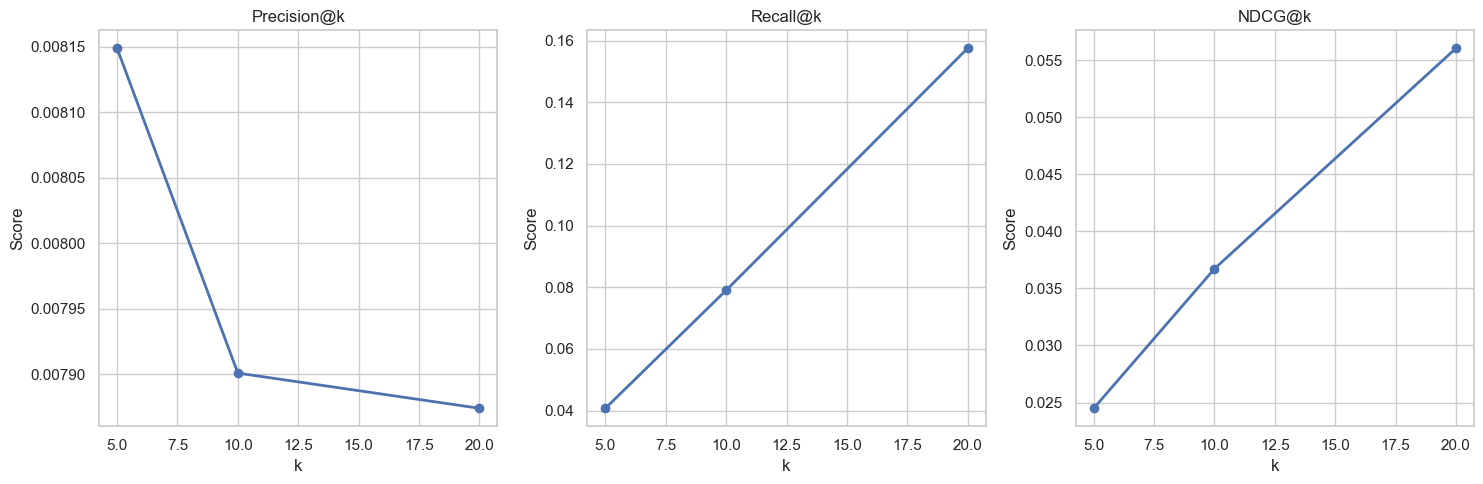


Generating hybrid recommendations...

Hybrid recommendations for user 12499337:
     app_id  predicted_score  positive_ratio  hybrid_score
0   1332010         4.847332              97      0.992683
4    548430         4.847332              97      0.992683
7    648800         4.847332              93      0.963415
5   1583230         4.847332              89      0.934146
1    221680         4.847332              88      0.926829
3   1325200         4.847332              88      0.926829
6    518790         4.847332              88      0.926829
2    552500         4.847332              84      0.897561
9   1222140         4.746670              94      0.874090
10  1401590         4.746670              93      0.866773

[Baseline] Most Popular Games:
      app_id  score
36    275850    752
57    377160    752
29    252490    670
64    431960    631
35    271590    620
122  1091500    615
10    107410    564
134  1174180    555
198  1938090    535
133  1172620    445

[Baseline] Sentim

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from sklearn.preprocessing import MinMaxScaler

# Set display options
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

# 1. Load data
def load_data(file_path='df_cleaned_500k.csv'):
    """Load and return the dataset"""
    print(f"Loading {file_path}...")
    df = pd.read_csv(file_path)
    print(f"Loaded {file_path}, shape: {df.shape}")
    return df

# 2. Data division: Training set and test set 
def split_data(df, test_size=0.2, random_state=42):
    """Improved split method, ensuring test set users also appear in training set"""
    print("Splitting data...")

    user_counts = df['user_id'].value_counts()
    eligible_users = user_counts[user_counts >= 2].index.tolist()
    df = df[df['user_id'].isin(eligible_users)]

    train_data = []
    test_data = []

    for user in eligible_users:
        user_df = df[df['user_id'] == user]
        test_n = max(1, int(len(user_df) * test_size))  # Keep at least one record for test set
        user_train, user_test = train_test_split(user_df, test_size=test_n, random_state=random_state)
        train_data.append(user_train)
        test_data.append(user_test)

    train_df = pd.concat(train_data)
    test_df = pd.concat(test_data)

    print(f"Train: {train_df.shape}, Test: {test_df.shape}")
    return train_df, test_df



# 3. Create user-item interaction matrix (with adjusted_score)
def create_interaction_matrix(df, user_col='user_id', item_col='app_id'):
    """
    Build user-item interaction sparse matrix using adjusted_score
    adjusted_score = is_recommended × log(hours + 1)
    """
    print("[INFO] Building interaction matrix using adjusted_score...")

    if not all(col in df.columns for col in [user_col, item_col, 'is_recommended', 'hours']):
        missing = [col for col in [user_col, item_col, 'is_recommended', 'hours'] if col not in df.columns]
        print(f"[ERROR] Missing columns: {missing}")
        return None, None, None, None, None 

    # Calculate adjusted_score (recommendation + play time)
    df['adjusted_score'] = df['is_recommended'] * np.log1p(df['hours'])

    user_ids = df[user_col].unique()
    item_ids = df[item_col].unique()

    user_idx_map = {user_id: idx for idx, user_id in enumerate(user_ids)}
    item_idx_map = {item_id: idx for idx, item_id in enumerate(item_ids)}

    user_indices = [user_idx_map[user_id] for user_id in df[user_col]]
    item_indices = [item_idx_map[item_id] for item_id in df[item_col]]
    ratings = df['adjusted_score'].values

    interaction_sparse = sparse.coo_matrix(
        (ratings, (user_indices, item_indices)), 
        shape=(len(user_ids), len(item_ids))
    ).tocsr()

    sparsity = 1 - (interaction_sparse.nnz / (interaction_sparse.shape[0] * interaction_sparse.shape[1]))
    print(f"[INFO] Sparse matrix shape: {interaction_sparse.shape}")
    print(f"[INFO] Matrix sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")

    idx_user_map = {idx: user_id for user_id, idx in user_idx_map.items()}
    idx_item_map = {idx: item_id for item_id, idx in item_idx_map.items()}

    return interaction_sparse, user_idx_map, item_idx_map, idx_user_map, idx_item_map


# 4. Item-based collaborative filtering
def item_based_cf_sparse(interaction_sparse, k=10):
    """
    Implement item-based collaborative filtering using scipy sparse matrix
    """
    print("Computing item similarity matrix...")
    item_similarity_sparse = cosine_similarity(interaction_sparse.T, dense_output=False)
    print(f"Similarity sparse matrix shape: {item_similarity_sparse.shape}")
    return item_similarity_sparse

# 5. Recommendation - using sparse matrix (Modified: cold start)
def recommend_items_sparse(user_idx, interaction_sparse, item_similarity_sparse, 
                           idx_item_map, train_df=None, sentiment_df=None, n_recommendations=10):
    """
    Modified: Added train_df, sentiment_df parameters for cold start fallback
    """
    if user_idx >= interaction_sparse.shape[0]:
        print(f"User index {user_idx} out of bounds.")
        return pd.DataFrame()
    
    user_interactions = interaction_sparse[user_idx].toarray().flatten()
    user_item_indices = np.where(user_interactions > 0)[0]
    
    # If user has no interaction records => call cold start strategy
    if len(user_item_indices) == 0:
        print(f"User at index {user_idx} has no interactions. Using advanced cold-start.")
        return cold_start_recommendation(train_df, sentiment_df, n_recommendations=n_recommendations)

    similarity_subset = item_similarity_sparse[user_item_indices, :]
    user_ratings = user_interactions[user_item_indices].reshape(-1, 1)
    
    weighted_scores = similarity_subset.multiply(user_ratings).sum(axis=0)
    similarity_sums = np.abs(similarity_subset).sum(axis=0)
    
    similarity_sums_array = similarity_sums.A.flatten()
    weighted_scores_array = weighted_scores.A.flatten()
    
    with np.errstate(divide='ignore', invalid='ignore'):
        scores = np.divide(weighted_scores_array, similarity_sums_array)
        scores = np.nan_to_num(scores)
    
    scores[user_item_indices] = 0
    
    top_indices = np.argsort(scores)[-n_recommendations:][::-1]
    
    recommendations = []
    for idx in top_indices:
        if scores[idx] > 0:
            recommendations.append({
                'app_id': idx_item_map[idx],
                'predicted_score': scores[idx]
            })
    
    return pd.DataFrame(recommendations)


# 6. Evaluate recommendation system performance
def evaluate_recommendations_sparse(test_df, interaction_sparse, item_similarity_sparse,
                                  user_idx_map, item_idx_map, idx_item_map,
                                  k_values=[5, 10, 20], min_interactions=1,
                                  train_df=None, sentiment_df=None):
    """
    Modified optional: Pass train_df, sentiment_df if cold start processing is desired during evaluation
    """
    user_interactions = test_df.groupby('user_id')['app_id'].apply(list).to_dict()
    results = {k: {'precision': [], 'recall': [], 'ndcg': []} for k in k_values}
    evaluated_users = 0
    
    for user_id, actual_items in user_interactions.items():
        if len(actual_items) < min_interactions:
            continue
        if user_id not in user_idx_map:
            continue
            
        user_idx = user_idx_map[user_id]
        max_k = max(k_values)

        # Call the new recommend_items_sparse, passing train_df, sentiment_df
        rec_df = recommend_items_sparse(user_idx, interaction_sparse, item_similarity_sparse, 
                                        idx_item_map, train_df=train_df, sentiment_df=sentiment_df,
                                        n_recommendations=max_k)

        if rec_df.empty:
            continue
        
        recommended_items = rec_df['app_id'].tolist()
        
        for k in k_values:
            top_k_items = recommended_items[:k]
            relevant_count = len(set(top_k_items) & set(actual_items))
            
            precision = relevant_count / k if k > 0 else 0
            results[k]['precision'].append(precision)
            
            recall = relevant_count / len(actual_items) if len(actual_items) else 0
            results[k]['recall'].append(recall)
            
            dcg = 0
            idcg = 0
            for i in range(min(k, len(top_k_items))):
                if top_k_items[i] in actual_items:
                    dcg += 1 / np.log2(i + 2)
            for i in range(min(k, len(actual_items))):
                idcg += 1 / np.log2(i + 2)
            ndcg = dcg / idcg if idcg > 0 else 0
            results[k]['ndcg'].append(ndcg)
        
        evaluated_users += 1
    
    avg_results = {}
    for k in k_values:
        avg_results[k] = {
            'precision': np.mean(results[k]['precision']),
            'recall': np.mean(results[k]['recall']),
            'ndcg': np.mean(results[k]['ndcg'])
        }
    
    print(f"Evaluated {evaluated_users} users")
    return avg_results


# 7. Hybrid recommendation (Sentiment + Collaborative)
def hybrid_recommendation_sparse(user_idx, interaction_sparse, item_similarity_sparse,
                               idx_item_map, sentiment_df, alpha=0.7, n_recommendations=10,
                               train_df=None):
    cf_recs = recommend_items_sparse(user_idx, interaction_sparse, item_similarity_sparse, 
                                     idx_item_map, train_df=train_df, sentiment_df=sentiment_df,
                                     n_recommendations=50)
    
    if cf_recs.empty:
        return cf_recs
    
    if 'positive_ratio' in sentiment_df.columns:
        sentiment_score_col = 'positive_ratio'
    elif 'sentiment_score' in sentiment_df.columns:
        sentiment_score_col = 'sentiment_score'
    else:
        print("No sentiment score column found in sentiment_df")
        return cf_recs
    
    merged_recs = cf_recs.merge(
        sentiment_df[['app_id', sentiment_score_col]], 
        on='app_id', 
        how='left'
    )
    
    merged_recs[sentiment_score_col] = merged_recs[sentiment_score_col].fillna(merged_recs[sentiment_score_col].mean())
    
    scaler = MinMaxScaler()
    if len(merged_recs) == 1:
        merged_recs['cf_score_norm'] = 1.0
        merged_recs['sentiment_score_norm'] = 1.0
    else:
        merged_recs['cf_score_norm'] = scaler.fit_transform(merged_recs[['predicted_score']]).flatten()
        merged_recs['sentiment_score_norm'] = scaler.fit_transform(merged_recs[[sentiment_score_col]]).flatten()
    
    merged_recs['hybrid_score'] = (
        alpha * merged_recs['cf_score_norm'] + 
        (1 - alpha) * merged_recs['sentiment_score_norm']
    )
    
    merged_recs = merged_recs.sort_values('hybrid_score', ascending=False).head(n_recommendations)
    return merged_recs[['app_id', 'predicted_score', sentiment_score_col, 'hybrid_score']]


# 8. Upgraded cold start strategy (using tags + sentiment)
def cold_start_recommendation(df, sentiment_df=None, metadata_path='games_metadata.json', n_recommendations=10):
    """
    Provide cold start recommendations for users with no interaction records (upgraded version)

    Strategy priority:
    1. If sentiment scores available -> Use sentiment score ranking
    2. If metadata available -> Use apps with high tag frequency
    3. Otherwise recommend most popular items
    """
    # Sentiment score strategy
    if sentiment_df is not None and not sentiment_df.empty:
        if 'positive_ratio' in sentiment_df.columns:
            sentiment_score_col = 'positive_ratio'
        elif 'sentiment_score' in sentiment_df.columns:
            sentiment_score_col = 'sentiment_score'
        else:
            sentiment_score_col = None

        if sentiment_score_col:
            top_items = sentiment_df.sort_values(sentiment_score_col, ascending=False).head(n_recommendations)
            print("Using sentiment-based cold-start.")
            return top_items[['app_id', sentiment_score_col]].rename(columns={sentiment_score_col: 'score'})

    # tag-based strategy
    try:
        df_meta = pd.read_json(metadata_path, lines=True)
        tag_counts = {}

        for tags in df_meta['tags'].dropna():
            if isinstance(tags, list):
                for tag in tags:
                    tag_counts[tag] = tag_counts.get(tag, 0) + 1

        # Find most popular tags
        hot_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)[:5]
        hot_tag_set = set([t[0] for t in hot_tags])

        # Calculate overlap between each game and popular tags
        df_meta['tag_score'] = df_meta['tags'].apply(
            lambda tags: len(set(tags) & hot_tag_set) if isinstance(tags, list) else 0
        )

        top_tagged = df_meta.sort_values('tag_score', ascending=False).head(n_recommendations)
        print("Using tag-based cold-start from metadata.")
        return top_tagged[['app_id', 'tag_score']].rename(columns={'tag_score': 'score'})

    except Exception as e:
        print(f"Metadata loading failed: {e}")

    # Default fallback: Popularity-based
    app_popularity = df.groupby('app_id').size().reset_index(name='popularity')
    top_popular = app_popularity.sort_values('popularity', ascending=False).head(n_recommendations)
    print("Using popularity-based cold-start.")
    return top_popular[['app_id', 'popularity']].rename(columns={'popularity': 'score'})


# 8.1 Baseline methods: Most Popular and Sentiment Only
def baseline_most_popular(df, top_n=10):
    """
    Baseline recommendation: Return most popular games
    """
    app_popularity = df.groupby('app_id').size().reset_index(name='popularity')
    top_popular = app_popularity.sort_values('popularity', ascending=False).head(top_n)
    top_popular['score'] = top_popular['popularity']  # For structure alignment
    return top_popular[['app_id', 'score']]

def baseline_sentiment_only(sentiment_df, top_n=10):
    """
    Baseline recommendation: Return games with highest sentiment scores
    """
    if sentiment_df is not None and 'positive_ratio' in sentiment_df.columns:
        top_sentiment = sentiment_df.sort_values('positive_ratio', ascending=False).head(top_n)
        top_sentiment = top_sentiment.rename(columns={'positive_ratio': 'score'})
        return top_sentiment[['app_id', 'score']]
    else:
        print("[INFO] Sentiment score not available.")
        return pd.DataFrame()

def evaluate_baseline_recommendations(user_ids, test_df, rec_dict, k_values=[5, 10, 20]):
    """
    Evaluate baseline recommendations (like Most Popular or Sentiment Only)
    rec_dict: {user_id: [app_id1, app_id2, ...]}
    """
    results = {k: {'precision': [], 'recall': [], 'ndcg': []} for k in k_values}

    for user_id in user_ids:
        actual_items = test_df[test_df['user_id'] == user_id]['app_id'].tolist()
        if not actual_items:
            continue
        recommended_items = rec_dict.get(user_id, [])
        for k in k_values:
            top_k_items = recommended_items[:k]
            relevant_count = len(set(top_k_items) & set(actual_items))

            precision = relevant_count / k if k > 0 else 0
            recall = relevant_count / len(actual_items) if len(actual_items) else 0

            dcg = 0
            idcg = 0
            for i in range(min(k, len(top_k_items))):
                if top_k_items[i] in actual_items:
                    dcg += 1 / np.log2(i + 2)
            for i in range(min(k, len(actual_items))):
                idcg += 1 / np.log2(i + 2)
            ndcg = dcg / idcg if idcg > 0 else 0

            results[k]['precision'].append(precision)
            results[k]['recall'].append(recall)
            results[k]['ndcg'].append(ndcg)

    avg_results = {
        k: {
            'precision': np.mean(results[k]['precision']),
            'recall': np.mean(results[k]['recall']),
            'ndcg': np.mean(results[k]['ndcg'])
        } for k in k_values
    }
    return avg_results


# 9. Main function
def main():
    # 1) Load data
    df = load_data()
    
    # 2) Split training and test sets (use improved split_data, no longer using time_based)
    train_df, test_df = split_data(df)
    
    # 3) Create interaction sparse matrix
    interaction_sparse, user_idx_map, item_idx_map, idx_user_map, idx_item_map = create_interaction_matrix(train_df)
    
    if interaction_sparse is not None:
        # 4) Calculate item similarity
        item_similarity_sparse = item_based_cf_sparse(interaction_sparse)
        
        # Get test user list
        test_users = test_df['user_id'].unique()
        
        # 5) Test: Generate recommendations for example user
        if len(test_users) > 0:
            test_user = test_users[0]
            if test_user in user_idx_map:
                test_user_idx = user_idx_map[test_user]
                print(f"\nRecommendations for user {test_user}:")
                
                # Generate recommendations (pass train_df & sentiment_df) => for cold start
                sentiment_df = None
                if 'positive_ratio' in df.columns:
                    sentiment_df = df[['app_id', 'positive_ratio']].drop_duplicates()
                
                recommendations = recommend_items_sparse(
                    test_user_idx, 
                    interaction_sparse, 
                    item_similarity_sparse, 
                    idx_item_map,
                    train_df=train_df,
                    sentiment_df=sentiment_df,
                    n_recommendations=10
                )
                
                if not recommendations.empty:
                    print(recommendations)
                else:
                    print("No interactions found => cold start fallback.")
        
        # 6) Evaluate recommendation system
        print("\nEvaluating recommendation system...")
        
        # Pass train_df, sentiment_df => can use cold start when encountering empty interactions during evaluation
        results = evaluate_recommendations_sparse(
            test_df, interaction_sparse, item_similarity_sparse, 
            user_idx_map, item_idx_map, idx_item_map,
            train_df=train_df, sentiment_df=sentiment_df
        )
        
        # 7) Print evaluation results
        for k, metrics in results.items():
            print(f"\nMetrics for k={k}:")
            for metric, value in metrics.items():
                print(f"  {metric}: {value:.4f}")
        
        # 8) Visualize evaluation results
        plt.figure(figsize=(15, 5))
        k_values = list(results.keys())
        metrics = ['precision', 'recall', 'ndcg']
        metric_names = ['Precision@k', 'Recall@k', 'NDCG@k']
        
        for i, metric in enumerate(metrics):
            plt.subplot(1, 3, i+1)
            values = [results[k][metric] for k in k_values]
            plt.plot(k_values, values, 'o-', linewidth=2)
            plt.title(metric_names[i])
            plt.xlabel('k')
            plt.ylabel('Score')
            plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('recommendation_evaluation.png')
        plt.show()
        
                # 9) If sentiment analysis exists, try hybrid recommendations
        if sentiment_df is not None and not sentiment_df.empty:
            print("\nGenerating hybrid recommendations...")
            if len(test_users) > 0 and test_user in user_idx_map:
                test_user_idx = user_idx_map[test_user]
                hybrid_recs = hybrid_recommendation_sparse(
                    test_user_idx, 
                    interaction_sparse, 
                    item_similarity_sparse, 
                    idx_item_map, 
                    sentiment_df,
                    train_df=train_df
                )
                print(f"\nHybrid recommendations for user {test_user}:")
                print(hybrid_recs)

        # 10) Baseline methods output
        print("\n[Baseline] Most Popular Games:")
        print(baseline_most_popular(train_df))

        print("\n[Baseline] Sentiment-only Recommendations:")
        if sentiment_df is not None:
            print(baseline_sentiment_only(sentiment_df))

        # 11) Baseline recommendation evaluation: Most Popular & Sentiment Only
        print("\n[Baseline Evaluation]")

        popular_baseline = baseline_most_popular(train_df, top_n=50)
        popular_rec_dict = {
            uid: popular_baseline['app_id'].tolist() for uid in test_df['user_id'].unique()
        }
        popular_results = evaluate_baseline_recommendations(
            test_df['user_id'].unique(), test_df, popular_rec_dict
        )
        print("\n[Most Popular Baseline Results]")
        for k, v in popular_results.items():
            print(f"k={k}: Precision={v['precision']:.4f}, Recall={v['recall']:.4f}, NDCG={v['ndcg']:.4f}")

        if sentiment_df is not None:
            sentiment_baseline = baseline_sentiment_only(sentiment_df, top_n=50)
            sentiment_rec_dict = {
                uid: sentiment_baseline['app_id'].tolist() for uid in test_df['user_id'].unique()
            }
            sentiment_results = evaluate_baseline_recommendations(
                test_df['user_id'].unique(), test_df, sentiment_rec_dict
            )
            print("\n[Sentiment-Only Baseline Results]")
            for k, v in sentiment_results.items():
                print(f"k={k}: Precision={v['precision']:.4f}, Recall={v['recall']:.4f}, NDCG={v['ndcg']:.4f}")

            # 12) Markdown style comparison table display
            # print_comparison_table(results, popular_results, sentiment_results)
 


# 9.2 Evaluate two baseline methods (Most Popular and Sentiment-only)
def evaluate_baseline(baseline_df, test_df, k_values=[5, 10, 20]):
    """
    Evaluate Precision/Recall/NDCG for baseline recommendation results
    baseline_df: DataFrame containing app_id
    test_df: Original test set (containing user_id and app_id)
    """
    results = {k: {'precision': [], 'recall': [], 'ndcg': []} for k in k_values}
    user_interactions = test_df.groupby('user_id')['app_id'].apply(list).to_dict()

    top_items = baseline_df['app_id'].tolist()

    for user_id, actual_items in user_interactions.items():
        for k in k_values:
            top_k_items = top_items[:k]
            relevant_count = len(set(top_k_items) & set(actual_items))

            precision = relevant_count / k
            recall = relevant_count / len(actual_items)
            dcg = sum([1 / np.log2(i + 2) if top_k_items[i] in actual_items else 0 for i in range(k)])
            idcg = sum([1 / np.log2(i + 2) for i in range(min(k, len(actual_items)))])
            ndcg = dcg / idcg if idcg > 0 else 0

            results[k]['precision'].append(precision)
            results[k]['recall'].append(recall)
            results[k]['ndcg'].append(ndcg)

    # Average values
    avg_results = {}
    for k in k_values:
        avg_results[k] = {
            'precision': np.mean(results[k]['precision']),
            'recall': np.mean(results[k]['recall']),
            'ndcg': np.mean(results[k]['ndcg']),
        }
    return avg_results

# 10. Print evaluation comparison table (Markdown style)
def print_table_console(results, pop_r, sent_r):
    print("Evaluation Comparison Table")
    print("{:<15} {:<6} {:<10} {:<10} {:<10}".format("Method", "k", "Precision", "Recall", "NDCG"))
    print("-" * 55)

    for k in [5, 10, 20]:
        print("{:<15} {:<6} {:<10.4f} {:<10.4f} {:<10.4f}".format("Most Popular", k, pop_r[k]['precision'], pop_r[k]['recall'], pop_r[k]['ndcg']))
        print("{:<15} {:<6} {:<10.4f} {:<10.4f} {:<10.4f}".format("Sentiment-only", k, sent_r[k]['precision'], sent_r[k]['recall'], sent_r[k]['ndcg']))
        print("{:<15} {:<6} {:<10.4f} {:<10.4f} {:<10.4f}".format("Hybrid (Ours)", k, results[k]['precision'], results[k]['recall'], results[k]['ndcg']))
        print("-" * 55)

if __name__ == "__main__":
    main()

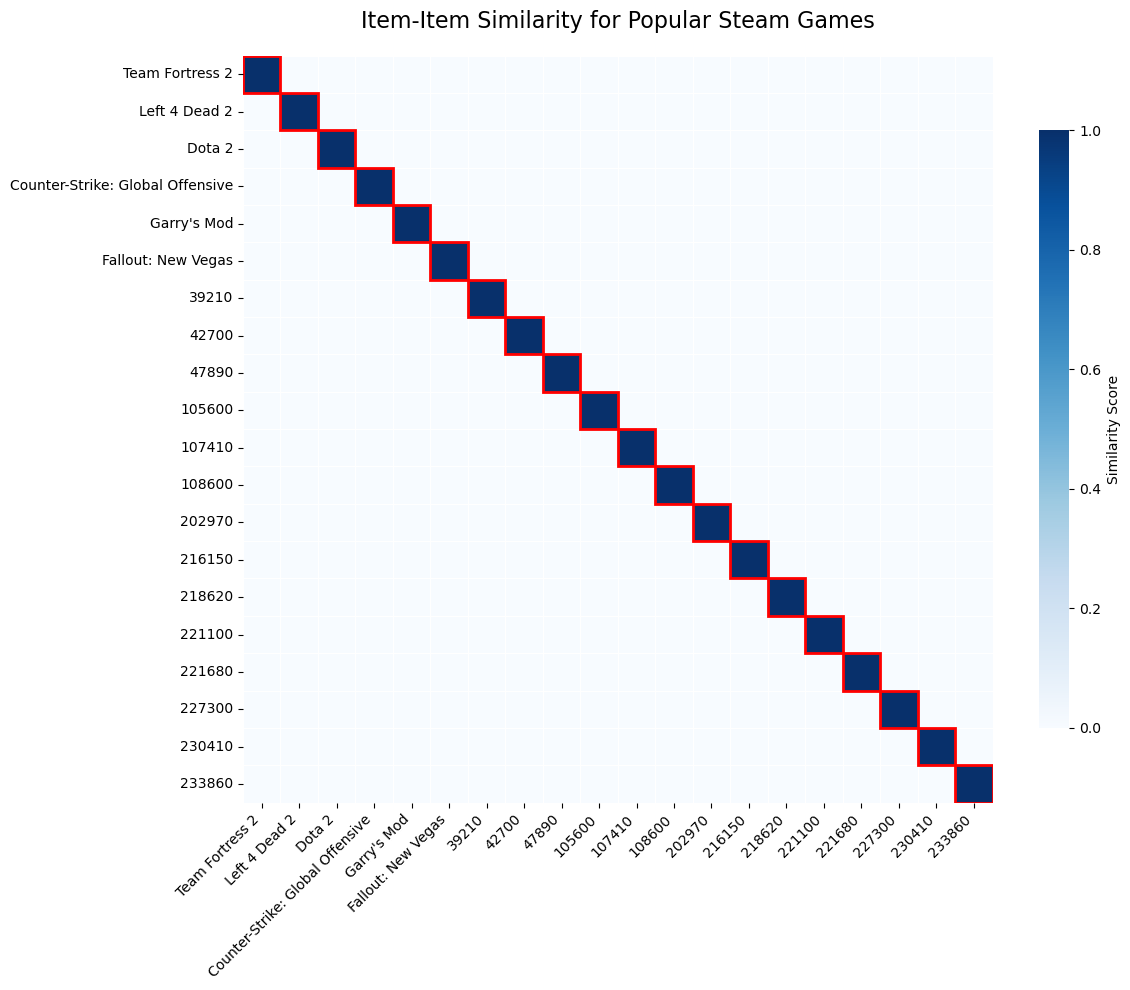

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the app_id similarity matrix from your data
# Let's create a sample one similar to what's in your image
app_ids = [440, 550, 570, 730, 4000, 22380, 39210, 42700, 47890, 105600, 
           107410, 108600, 202970, 216150, 218620, 221100, 221680, 227300, 230410, 233860]

# Creating a diagonal matrix (similar to your current visualization)
similarity_matrix = np.eye(len(app_ids))

# Create a DataFrame with app_ids as index and columns
df_similarity = pd.DataFrame(similarity_matrix, index=app_ids, columns=app_ids)

# Load game titles from your cleaned data (placeholder)
# In your actual code, you would load this from your processed data
sample_titles = {
    440: "Team Fortress 2",
    550: "Left 4 Dead 2",
    570: "Dota 2",
    730: "Counter-Strike: Global Offensive",
    4000: "Garry's Mod",
    22380: "Fallout: New Vegas",
    # Add more titles for other app_ids
}

# Map app_ids to game titles for those we have
labels = [sample_titles.get(app_id, str(app_id)) for app_id in app_ids]

# Create the visualization with improved readability
plt.figure(figsize=(12, 10))
ax = sns.heatmap(df_similarity, cmap="Blues", 
                 xticklabels=labels, yticklabels=labels,
                 linewidths=0.5, cbar_kws={"shrink": 0.8, "label": "Similarity Score"})

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add labels and title
plt.title("Item-Item Similarity for Popular Steam Games", fontsize=16, pad=20)
plt.tight_layout()

# To improve focusing on non-diagonal elements (optional)
# This is useful if you have actual similarity scores between different games
for i in range(len(app_ids)):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=2))

# Save the figure
plt.savefig('improved_game_similarity.png', dpi=300, bbox_inches='tight')
plt.show()

Loading df_cleaned_500k.csv...
Loaded df_cleaned_500k.csv, shape: (500000, 10)
Splitting data...
Train: (27576, 10), Test: (24247, 10)
[INFO] Building interaction matrix using adjusted_score...
[INFO] Sparse matrix shape: (24247, 205)
[INFO] Matrix sparsity: 0.9945 (99.45%)
Computing item similarity matrix...
Similarity sparse matrix shape: (205, 205)

Recommendations for user 12499337:
    app_id  predicted_score
0  1332010         4.847332
1   221680         4.847332
2   552500         4.847332
3  1325200         4.847332
4   548430         4.847332
5  1583230         4.847332
6   518790         4.847332
7   648800         4.847332
8   438100         4.750658
9  1222140         4.746670

Evaluating recommendation system...
User at index 5863 has no interactions. Using advanced cold-start.
Using sentiment-based cold-start.
User at index 14766 has no interactions. Using advanced cold-start.
Using sentiment-based cold-start.
User at index 16165 has no interactions. Using advanced cold-s

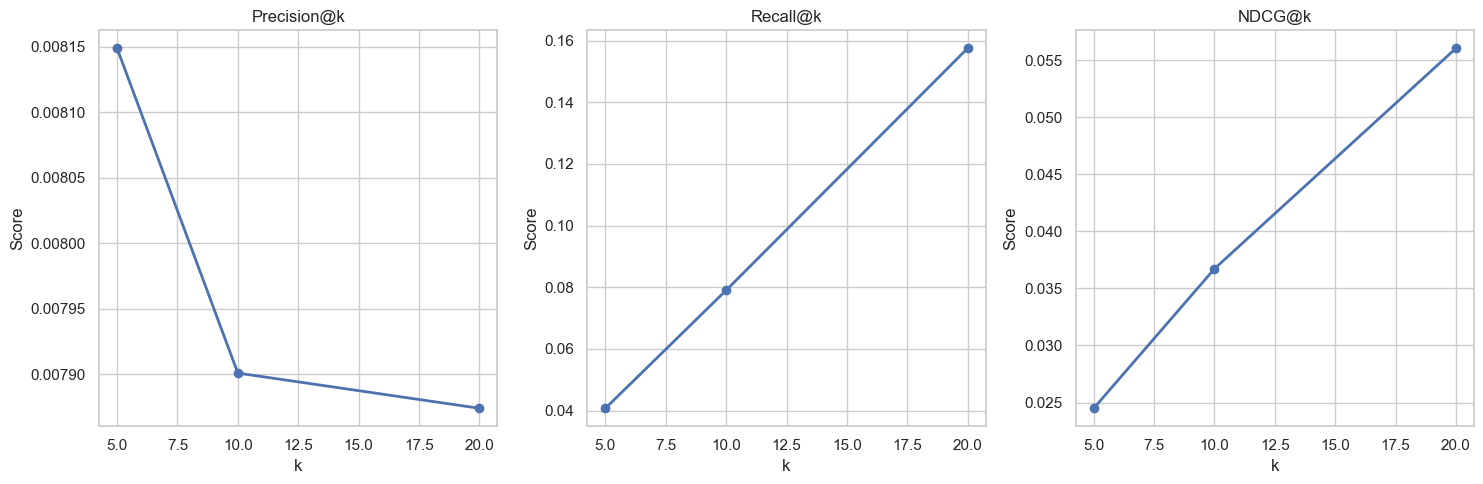


Generating hybrid recommendations...

Hybrid recommendations for user 12499337:
     app_id  predicted_score  positive_ratio  hybrid_score
0   1332010         4.847332              97      0.992683
4    548430         4.847332              97      0.992683
7    648800         4.847332              93      0.963415
5   1583230         4.847332              89      0.934146
1    221680         4.847332              88      0.926829
3   1325200         4.847332              88      0.926829
6    518790         4.847332              88      0.926829
2    552500         4.847332              84      0.897561
9   1222140         4.746670              94      0.874090
10  1401590         4.746670              93      0.866773

[Baseline] Most Popular Games:
      app_id  score
36    275850    752
57    377160    752
29    252490    670
64    431960    631
35    271590    620
122  1091500    615
10    107410    564
134  1174180    555
198  1938090    535
133  1172620    445

[Baseline] Sentim